# Tutorial for TSP Problem

## Write TSP mathematical model with jijmodeling
Usually, we need several steps to solve a mathematical optimization problem with a quantum algorithm such as QAOA or VQE.
The steps are

1. describe the mathematical model
2. transform the mathematical model into QUBO form
3. transform the QUBO form into the Ising form
In this section, we will look at these steps specifically using the TSP.

First, let us describe the mathematical model of the TSP.
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n}\\
\mathrm{s.t.}~&\sum_i x_{i, t} = 1,~\forall t\\
&\sum_t x_{i, t} = 1, ~\forall i\\
&x_{i, t} \in \{0, 1\}
\end{aligned}
$$
where $d_{i,j}$ is distance between city $i$ and city $j$.
A detailed description of the mathematical model is omitted, but the important point here is that merely describing the mathematical model is not a form that can be handled by quantum algorithms.

Next, the mathematical model needs to be converted to Quadratic Unconstraint Binary Optimisation (QUBO) format.
A typical conversion method is the Penalty method. This is a method for transforming a mathematical model into the following form.
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

Finally, this QUBO form needs to be converted to Ising form.
In other words, it is necessary to convert the QUBO into the Ising model by converting the binary variables into spin variables as $x_i = \frac{1}{2}(1 - z_i)$.
Here, the specific calculations are too cumbersome to write down, but formally, the conversion is as follows
$$
\begin{aligned}
\sum_{i,j} Q_{i,j}x_i,x_j \to \sum_{i,j}J_{i,j}z_iz_j + \sum_ih_i z_i 
\end{aligned}
$$
Now, as can be seen from the above, it is quite tedious just to convert a mathematical model. The most of the researcher would like to build their own algorithm, but building the Hamiltonian.

Therefore, `jijtranspiler_qiskit` is a tool that automatically performs the tediousness of the above conversion.

Let's see how to use it concretely below.

In [1]:
import jijmodeling as jm
import jijmodeling.transpiler as jmt
from jijtranspiler_qiskit.qaoa import transpile_to_qaoa_ansatz

import qiskit as qk
import numpy as np
import matplotlib.pyplot as plt

First, the mathematical model is described using JijModeling.

Here, the variables used in the mathematical model are defined, and the objective function and constraints are described using these variables.

In [2]:
# define variables
d = jm.Placeholder('d', dim=2)
N = d.shape[0].set_latex("N")
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, N))
t = jm.Element('t', (0, N))
x = jm.Binary('x', shape=(N, N))

# set problem
problem = jm.Problem('TSP')
problem += jm.Sum([i, j], d[i, j] * jm.Sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", jm.Sum(i,x[i, t]) == 1, forall=t)
problem += jm.Constraint("one-time", jm.Sum(t,x[i, t]) == 1, forall=i)
problem

/tmp/ipykernel_135636/24099923.py:2: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  d = jm.Placeholder('d', dim=2)
/tmp/ipykernel_135636/24099923.py:4: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  i = jm.Element('i', (0, N))
/tmp/ipykernel_135636/24099923.py:5: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  j = jm.Element('j', (0, N))
/tmp/ipykernel_135636/24099923.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  t = jm.Element('t', (0, N))
/tmp/ipykernel_135636/24099923.py:7: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=(N, N

JijModeling allows you to check the mathematical model in Tex format, as described above, and to check whether the mathematical model you have programmed matches the mathematical model you have written at hand.

## Generate instance and check with jijbench
Next, a simple problem should be created to solve the actual problem.
Here, as an example, we will solve a three-city TSP placed in Random.

In [3]:
def generate_random_instance(n):
    x_pos = np.random.rand(n)
    y_pos = np.random.rand(n)
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2)
    return x_pos, y_pos, distance

In [24]:
x_pos, y_pos, distance = generate_random_instance(4)

For visualisation, JijBench, a visualisation function in the experiment management tool for mathematical optimisation created by Jij, is used here.

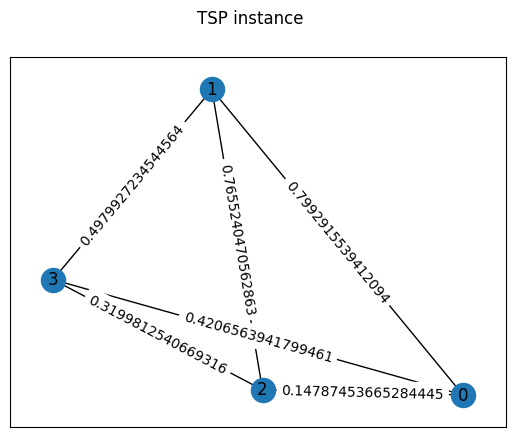

In [25]:
from jijbench.visualization import Graph,GraphType

graph = Graph.from_distance_matrix(distance,graphtype=GraphType.UNDIRECTED)
node_pos = {i:(x,y) for i,(x,y) in enumerate(zip(x_pos,y_pos))}
graph.show(node_pos=node_pos,title="TSP instance")

## Generate Qiskit Hamiltonian with jijtranspiler_qiskit

The next step is to actually transform the mathematical model. Here, it is transformed so that it can be solved in Qiskit.
First of all, the mathematical model is converted so that it can be processed internally, given the created mathematical model and problem instances.

In [26]:
compiled_instance = jmt.core.compile_model(problem, {"d": distance})

<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_penalty` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_multiplier` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `auto_qubo` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `label` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `name` instead.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `condition` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `expression` instead.


Next, set up information such as how QUBOs are to be converted in order to create QAOA Ansatz.
For example, how the mathematical model is to be converted to QUBO can also be set. The Penalty method or the Augment Lagrangian method as described above can also be used for conversion.

Augumented Lagrangian Method : Adding Linear and Quadratic term to Objective function
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \xi_t \left(\sum_i x_{i, t} - 1\right) + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \zeta_i \left(\sum_t x_{i, t} - 1 \right) +  \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

In [27]:
qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance,relax_method = jmt.core.pubo.RelaxationMethod.SquaredPenalty)

# You can also use Augumented Lagrangian method to build QUBO
# qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance,relax_method = jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)

Finally, `get_qaoa_ansatz` can be used to obtain the parametrized circuit, objective function, etc. of the QAOA.
At this time, the number of layers of QAOA and the coefficients of the above Penalty method can also be set in detail. (Default value is 1).

In [28]:
qaoa_ansatz, cost_func, constant = qaoa_builder.get_qaoa_ansatz(p=1,detail_parameters = {'one-city':{(1,): (2, 1)},'one-time':{(1,): (2, 1)}})

Now that the qiskit QAOA circuit has been obtained, programming can be carried out using qiskit from this point onwards.

In [29]:
qaoa_ansatz.measure_all()
qaoa_ansatz.decompose().draw('text')

┌───┐»
    q_0: ┤ H ├»
         ├───┤»
    q_1: ┤ H ├»
         ├───┤»
    q_2: ┤ H ├»
         ├───┤»
    q_3: ┤ H ├»
         ├───┤»
    q_4: ┤ H ├»
         ├───┤»
    q_5: ┤ H ├»
         ├───┤»
    q_6: ┤ H ├»
         ├───┤»
    q_7: ┤ H ├»
         ├───┤»
    q_8: ┤ H ├»
         ├───┤»
    q_9: ┤ H ├»
         ├───┤»
   q_10: ┤ H ├»
         ├───┤»
   q_11: ┤ H ├»
         ├───┤»
   q_12: ┤ H ├»
         ├───┤»
   q_13: ┤ H ├»
         ├───┤»
   q_14: ┤ H ├»
         ├───┤»
   q_15: ┤ H ├»
         └───┘»
meas: 16/═════»
              »
«         ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«    q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [30]:
cost_func

SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIZZIIIIII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIZIIII', 'IIIIZIIIIZIIIIII', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIZII', 'IZIIIIIIIIIZIIII', 'ZIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIZIIZIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIZZIIIIIII', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIZIII', 'IIIIZIIIIIZIIIII', 'IIIZIIIIZIIIIIII', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIZIII', 'ZIIIIIIIIIZIIIII', 'IIIIZIIIIIIIIZII', 'IIIIIIIZIIIZIIII', 'IIIIIIZIIZIIIIII', 'IIIIIZIIIIIIIIIZ', 'IIIIZIIIIIIIIIZI', 'IIIIIIIZIIIIZIII', 'IIIIIIZIIIZIIIII', 'IIIIIZIIZIIIIIII', 'IIIZZIIIIIIIIIII', 'IIZI

# Run QAOA

In [31]:
from qiskit.primitives import Estimator, Sampler
from scipy.optimize import minimize

`transpiler_qiskit` to create Ansatz and Hamiltonians.

In [32]:
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(p=1,multipliers = {'one-city':1,'one-time':1})

Define the cost function. Here, the `Estimator` of `qiskit.primitive` is used to calculate the expected value.

In [33]:
def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

In [34]:
initial_params = [1.0, 0.6]
estimator = Estimator()
optimization_history = []
qaoa_result = minimize(cost_func, initial_params, args=(qaoa_ansatz, hamiltonian, estimator), method='COBYLA',callback = lambda x:optimization_history.append(cost_func(x,qaoa_ansatz, hamiltonian, estimator)))

It can be seen that the expected value has decreased as a result of parameter optimisation.

Text(0, 0.5, 'cost function')

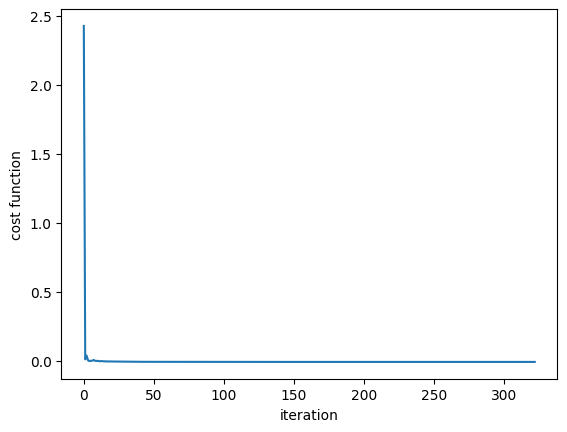

In [35]:
plt.plot(optimization_history)
plt.xlabel('iteration')
plt.ylabel('cost function')

The solution is then Sampled using the optimal parameters obtained.

In [36]:
qaoa_ansatz.measure_all()

In [37]:

sampler = Sampler()
job = sampler.run(qaoa_ansatz, qaoa_result.x)
result = job.result().quasi_dists
decoded_results = qaoa_builder.decode_from_quasi_dist(result[0])
# qaoa_builder.decode_from_counts()
print(decoded_results)

SampleSet(record=Record(solution={'x': [(([], []), [], (4, 4)), (([3], [0]), [1], (4, 4)), (([3], [3]), [1], (4, 4)), (([3, 3], [3, 0]), [1, 1], (4, 4)), (([3], [2]), [1], (4, 4)), (([3, 3], [2, 0]), [1, 1], (4, 4)), (([3, 3], [2, 3]), [1, 1], (4, 4)), (([3, 3, 3], [2, 3, 0]), [1, 1, 1], (4, 4)), (([3], [1]), [1], (4, 4)), (([3, 3], [1, 0]), [1, 1], (4, 4)), (([3, 3], [1, 3]), [1, 1], (4, 4)), (([3, 3, 3], [1, 3, 0]), [1, 1, 1], (4, 4)), (([3, 3], [1, 2]), [1, 1], (4, 4)), (([3, 3, 3], [1, 2, 0]), [1, 1, 1], (4, 4)), (([3, 3, 3], [1, 2, 3]), [1, 1, 1], (4, 4)), (([3, 3, 3, 3], [1, 2, 3, 0]), [1, 1, 1, 1], (4, 4)), (([2], [0]), [1], (4, 4)), (([2, 3], [0, 0]), [1, 1], (4, 4)), (([2, 3], [0, 3]), [1, 1], (4, 4)), (([2, 3, 3], [0, 3, 0]), [1, 1, 1], (4, 4)), (([2, 3], [0, 2]), [1, 1], (4, 4)), (([2, 3, 3], [0, 2, 0]), [1, 1, 1], (4, 4)), (([2, 3, 3], [0, 2, 3]), [1, 1, 1], (4, 4)), (([2, 3, 3, 3], [0, 2, 3, 0]), [1, 1, 1, 1], (4, 4)), (([2, 3], [0, 1]), [1, 1], (4, 4)), (([2, 3, 3], [0, 1

For sampling results on Hamiltonians obtained using `transpiler_qiskit`, the decode function can be used to convert them into a more readable and analyseable form.
For example, the decoded results can be used with the `feasible` method to extract only feasible solutions.

In [38]:
feasible_result = decoded_results.feasible()
feasible_result.to_dense()

SampleSet(record=Record(solution={'x': [array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]]), array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]]), array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]]), array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]]), array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]]), array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]]), array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]]), array([[0., 1., 0., 0.],
       [1., 0., 0

Let's look at what, for the feasible solutions obtained, tour is the objective function value.

In [39]:
import networkx as nx
def plot_tour(ax,G,node_pos):
    nx.draw_networkx_nodes(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    nx.draw_networkx_edges(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    node_labels = {node: str(node) for node in G.nodes}
    nx.draw_networkx_labels(
            G=G,
            pos=node_pos,
            labels=node_labels,
            ax=ax,
        )

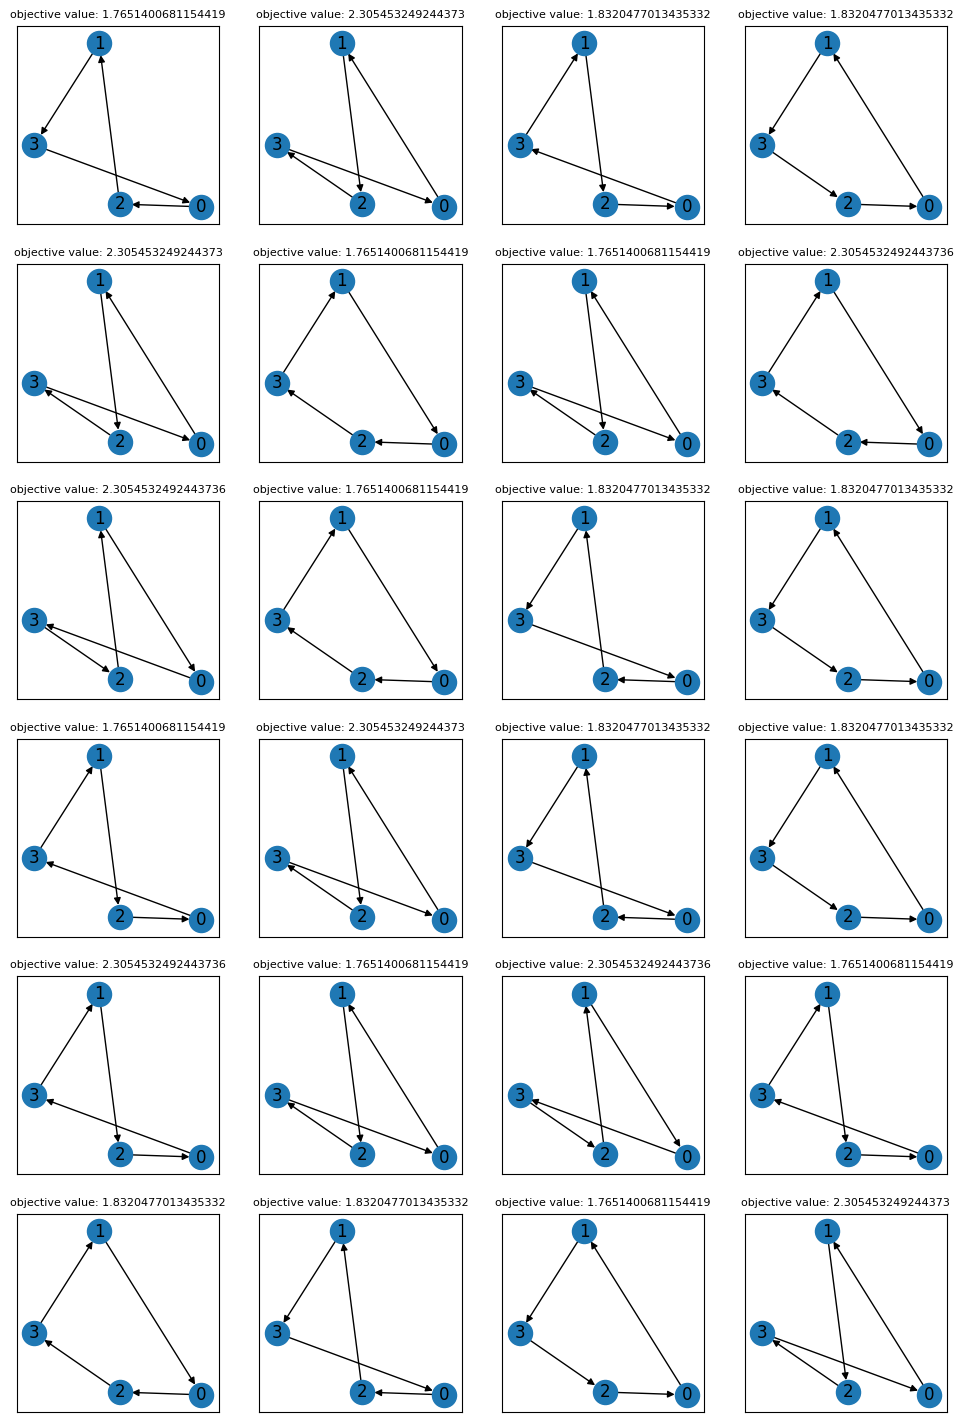

In [40]:
# 画像を横に並べるための設定
num_images = len(feasible_result)
columns = 4  # 一行に表示する画像の数
rows = (num_images - 1) // columns + 1  # 行数の計算

# 画像を横並びに表示するためのサブプロットの設定
fig, axes = plt.subplots(rows, columns, figsize=(12, 3*rows))

for i, objective_value in enumerate(feasible_result.evaluation.objective):
    ax = axes[i // columns, i % columns] 
    (time_order, route), value,matrix_shape = decoded_results.feasible().record.solution['x'][i]
    edge = [[route[i],route[i+1]] for i in range(len(route)-1)] + [[route[-1],route[0]]]
    graph = Graph.from_edge_list(edge_list=edge,graphtype=GraphType.DIRECTED)
    plot_tour(ax=ax,G=graph.G,node_pos=node_pos)
    ax.set_title(f"objective value: {objective_value}",fontsize=8)